# Caso de uso: Agrupación de textos por temáticas similares
**Autor:** Unidad de Científicos de Datos (UCD)

---
Este es un caso de uso que utiliza varias funcionalidades de la libtería **ConTexto** para procesar y vectorizar textos de noticias sobre diferentes temas. Luego, sobre estos vectores se aplica t-SNE, una técnica no lineal de reducción de dimensionalidad para transformar los vectores a un espacio bidimensional.

Una vez se tengan los vectores en 2 dimensiones, se graficarán con un color correspondiente al tema de cada texto. Esto permite observar si los puntos de cada tema quedan juntos entre sí y separados de los otros temas.

---

## 1. Cargar librerías necesarias y definir parámetros importantes para el caso de uso

El primer paso es cargar los módulos y las librerías necesarias para correr el caso de estudio. De parte de **ConTexto** se necesitan funciones del módulo de `limpieza`, para hacer un procesamiento básico de los textos y remover *stopwords* y el módulo de `vectorización`, para generar las representaciones vectoriales de los textos.

Adicionalmente, se importan los siguientes paquetes externos:

- `pyplot`: para generar y mostrar las gráficas.
- `manifold`, de `sklearn`: para hacer la reducción de dimensionalidad por medio de t-SNE.
- De `sklearn.datasets` se importa la función `fetch_20newsgroups`, que permite descargar noticias en inglés sobre 20 temas distintos. Para más información sobre este conjunto de datos, se puede consultar <a href="https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html" target="_blank">su documentación</a>.


In [1]:
# Componentes de ConTexto necesarios
from contexto.limpieza import limpieza_texto, lista_stopwords
from contexto.vectorizacion import *
from contexto.utils.auxiliares import verificar_crear_dir

# Librerías adicionales
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.datasets import fetch_20newsgroups


De los 20 temas disponibles en el conjunto de datos, se arman dos grupos, de 4 temas cada uno. La siguiente tabla muestra los temas que contiene cada grupo:

| Grupo 1              | Grupo 2                |
|----------------------|------------------------|
|Computación - Gráficos|Religión - Cristiana    |
|Deportes - Béisbol    |Alternativo - Ateísmo   |
|Ciencia - Medicina    |Religión - Miscelánea   |
|Política - Armas      |Política - Medio Oriente|

Como se puede ver, el grupo 1 tiene temas que son más diferentes entre sí, y por lo tanto los vectores resultantes deberían poderse ver más separados entre sí al graficarlos en dos dimensiones. Por el otro lado, el grupo 2 tiene temas con más cosas en común, por lo que en primera instancia puede que no sea tan fácil verlos separados.

Finalmente, se define una lista de vectorizadores a utilizar. Se utilizan los siguientes:

- BOW
- TF-IDF
- Hashing
- Doc2Vec
- Word2Vec
- Word2Vec - ignorando palabras desconocidas (Para mayor información sobre esto, consultar el ejemplo de vectorización)

In [2]:
# Temas que en principio son bastante diferentes entre sí, por lo que deberían
# ser más fáciles de agrupar
grupo_1 = ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'talk.politics.guns']

# Temas mucho más similares entre sí
grupo_2 = ['soc.religion.christian', 'alt.atheism', 'talk.religion.misc', 'talk.politics.mideast']

# Vectorizadores a considerar
vectorizadores = ['bow', 'tfidf', 'hash', 'doc2vec', 'word2vec', 'word2vec_conocidas']

---

## 2. Funciones de apoyo

A continuación se definen dos funciones, que se encargan de llevar a cabo lo siguiente:

- `graficar_textos`: Recibe un arreglo de vectores (de dos dimensiones) y sus respectivas etiquetas (el tema de cada texto). Esta función se encarga de pintar los vectores bidimensionales y asignar un color a cada punto, dependiendo de su respectivo tema. El parámetro *dir_salida* permite definir la carpeta en donde se guardarán los resultados. El nombre de cada gráfica depende del grupo de temas utilizado, de si se realizó normalización sobre los vectores de los textos y de un título que se asigne a la gráfica (parámetro *titulo*).
- `comparacion_vectorizadores`: Recibe el número que indica qué grupo de temas se va a tratar, una lista de vectorizadores a utilizar y un parámetro *normalizar*, que indica si se quiere hacer normalización min-max sobre los vectores generados para el grupo de textos. Esta normalización puede mejorar los resultados para algunos vectorizadores, en particular los basados en frecuencias (menos el TF-IDF, que ya hace una especie de normalización al tener en cuenta la frecuencia inversa en documentos de los términos). Ests función realiza todo el proceso, que consiste en:
  - Extraer las noticias de los temas del grupo determinado, utilizando la función `fetch_20newsgroups`.
  - Pre-procesar los textos, removiendo signos de puntuación y *stopwords*, además de pasar todo el texto a minúsculas.
  - Inicializar y ajustar (si aplica) los vectorizadores sobre el corpus de noticias.
  - Aplicar los vectorizadores para obtener las representaciones vectoriales de los textos.
  - Normalizar los vectores utilizando min-max, solo si se indicó en el parámetro *normalizar* de la función.
  - Aplicar la reducción de dimensionalidad, para llevar los vectores a 2 dimensiones. Este paso puede ser un poco demorado.
  - Utilizar la función `graficar_textos` para producir las gráficas.
  

In [3]:
# Función para graficar los puntos
def graficar_textos(X, y, titulo, num_grupo, norm, nombres, dir_salida='salida/caso_uso_vectores/'): 
    num_cats = len(np.unique(y))
    # Hasta 8 diferentes categorías
    colores = ['black', 'blue', 'yellow', 'red', 'green', 'orange', 'brown', 'purple']
    color_dict = {i:colores[i] for i in range(num_cats)}
    label_dict = {i:nombres[i] for i in range(num_cats)}
    fig, ax = plt.subplots(figsize=(10,10))
    for g in range(num_cats):
        ix = np.where(y == g)
        ax.scatter(X[ix,0], X[ix,1], c=color_dict[g], label=label_dict[g])
    # Convenciones
    plt.legend(loc="lower right", title="Clases")
    plt.xticks([]), plt.yticks([])
    plt.title(titulo)
    # Guardar la imagen resultante
    verificar_crear_dir(dir_salida)
    norm_str = '_norm' if norm else ''
    nombre_archivo = f'grupo_{num_grupo}_{titulo}{norm_str}.jpg'
    plt.savefig(dir_salida + nombre_archivo)
    plt.close()

In [4]:
def comparacion_vectorizadores(num_grupo, normalizar, vectorizadores=vectorizadores, dir_salida='salida/caso_uso_vectores/'):
    grupo = grupo_1 if num_grupo == 1 else grupo_2 
    # Obtener dataset de las categorías seleccionadas
    dataset = fetch_20newsgroups(subset='all', categories=grupo, shuffle=True, random_state=42)
    clases = dataset.target
    nombres_clases = dataset.target_names
    # Limpieza básica a los textos para quitar ruido
    # Tener en cuenta que los textos están en inglés
    textos_limpios = [limpieza_texto(i, lista_stopwords('en')) for i in dataset.data]
    # Inicializar los 5 vectorizadores. Todos se configuran para tener 300 elementos,
    # de modo que estén en igualdad de condiciones
    v_bow = VectorizadorFrecuencias(tipo='bow', max_elementos=500)
    v_tfidf = VectorizadorFrecuencias(tipo='tfidf', max_elementos=500)
    v_hash = VectorizadorHash(n_elementos=500)
    v_word2vec = VectorizadorWord2Vec('en')
    v_doc2vec = VectorizadorDoc2Vec(n_elementos=300)
    # Ajustar los modelos que deben ser ajustados sobre el corpus
    v_bow.ajustar(textos_limpios)
    v_tfidf.ajustar(textos_limpios)
    v_doc2vec.entrenar_modelo(textos_limpios)
    # Obtener los vectores para cada vectorizador
    dict_vectores = {}
    for v in vectorizadores:
        print(f'Vectorizando con técnica {v}...')
        if 'conocidas' in v:
            v_mod = v.split('_')[0]
            dict_vectores[v] = eval(f'v_{v_mod}.vectorizar(textos_limpios, quitar_desconocidas=True)')
        else:
            dict_vectores[v] = eval(f'v_{v}.vectorizar(textos_limpios)')
    # Normalizar los vectores
    if normalizar:
        for v in vectorizadores:
            min_v = dict_vectores[v].min(axis=0)
            max_v = dict_vectores[v].max(axis=0)
            dict_vectores[v] = (dict_vectores[v] - min_v) / (max_v - min_v)
    # Aplicar t-sne para dejar vectores en 2 dimensiones
    dict_tsne = {}
    for v in vectorizadores:
        print(f'Reducción de dimensionalidad a vector {v}...')
        dict_tsne[v] = manifold.TSNE(n_components=2, init="pca").fit_transform(dict_vectores[v])
    # Graficar los puntos para cada técnica
    for v in vectorizadores:
        graficar_textos(dict_tsne[v], clases, v, num_grupo, normalizar, nombres_clases, dir_salida=dir_salida)


---

## 3. Realizar el barrido, para generar las gráficas y comparar

A continuación se hace un barrido para ambos grupos de noticias (1 y 2) y ambas opciones de normalizar (hacerlo o no hacerlo), para generar todas las gráficas, y así poder determinar qué vectorizadores generan vectores más "separables" en cada caso.

In [5]:
# Barrido para realizar las pruebas
for num_grupo in [1, 2]:
    for normalizar in [True, False]:
        print(f'\n -------------- Grupo: {num_grupo}, normalizar: {normalizar}')
        comparacion_vectorizadores(num_grupo, normalizar, vectorizadores=vectorizadores)


 -------------- Grupo: 1, normalizar: True
Vectorizando con técnica bow...
Vectorizando con técnica tfidf...
Vectorizando con técnica hash...
Vectorizando con técnica doc2vec...
Vectorizando con técnica word2vec...
Vectorizando con técnica word2vec_conocidas...
Reducción de dimensionalidad a vector bow...
Reducción de dimensionalidad a vector tfidf...
Reducción de dimensionalidad a vector hash...
Reducción de dimensionalidad a vector doc2vec...
Reducción de dimensionalidad a vector word2vec...
Reducción de dimensionalidad a vector word2vec_conocidas...

 -------------- Grupo: 1, normalizar: False
Vectorizando con técnica bow...
Vectorizando con técnica tfidf...
Vectorizando con técnica hash...
Vectorizando con técnica doc2vec...
Vectorizando con técnica word2vec...
Vectorizando con técnica word2vec_conocidas...
Reducción de dimensionalidad a vector bow...
Reducción de dimensionalidad a vector tfidf...
Reducción de dimensionalidad a vector hash...
Reducción de dimensionalidad a vector 

---

## 4. Resultados
Las imágenes de los resultados quedarán guardadas en la carpeta especificada en el parámetro *dir_salida*. Todas las combinaciones de vectorizadores, grupo y normalización producen 24 imágenes.

A continuación se muestra la imagen obtenida para el grupo uno con el vectorizador Word2Vec, sin tener en cuenta palabras desconocidas y sin normalizar. Se puede ver que en este caso los textos aparecen agrupados por temas, con algunas pocas excepciones.

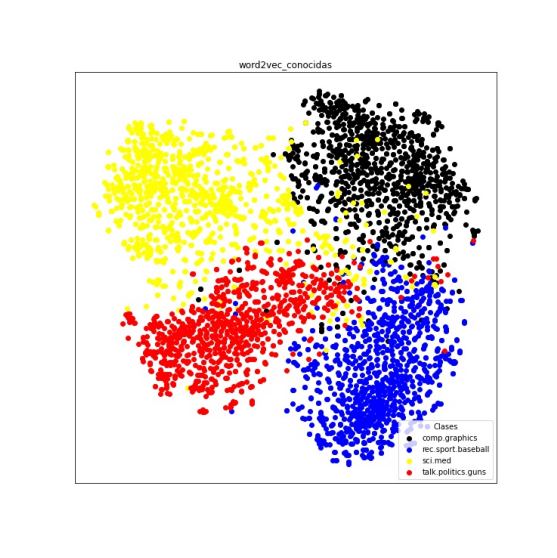

In [12]:
import matplotlib.image as mpimg

img = mpimg.imread('salida/caso_uso_vectores/grupo_1_word2vec_conocidas.jpg')
plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Por otro lado, en el grupo 2 los resultados no son tan buenos. Esto era de esperarse, dado que los temas en este grupo son más cercanos entre sí. A continuación se muestra la gráfica obtenida con el vectoriador Doc2Vec sin normalizar. Se puede ver que, aunque los textos salen mucho más mezclados entre sí, el tema de *Política - Medio oriente*, que en el papel era el más distinto de los 4, sale más separado del resto.

Es importante recordar que en este caso de uso solo se hizo una vectorización, seguida de reducción de dimensionalidad. El entrenamiento de otros modelos no supervisados (*clustering*) o supervisados (modelos de clasificación multiclase) pueden llevar a mejores resultados.

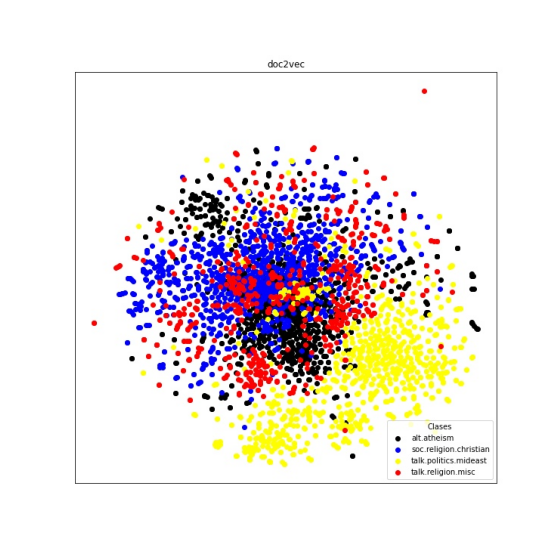

In [13]:
img = mpimg.imread('salida/caso_uso_vectores/grupo_2_doc2vec.jpg')
plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()